<a href="https://colab.research.google.com/github/aakhterov/ML_algorithms_from_scratch/blob/master/machine_translation_using_bahdanau_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Description

We're going to build an NN model to translate from Russian to English. This notebook is committed to the implementation of the simple encoder-decoder network with LSTM elements.

We will use the following terms:
- source language - the language from which the model translates
- target language - the language to which the model translates
- token = word


Dataset: https://www.kaggle.com/datasets/hijest/englishrussian-dictionary-for-machine-translate/

References:
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb
- https://www.youtube.com/watch?v=vI2Y3I-JI2Q
- https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b



In [34]:
from typing import List
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from string import punctuation
from collections import Counter
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Vectorization

In [3]:
UNKNOWN_TOKEN = '[UNK]' # Out of vocabulary token
START_TOKEN = '[START]' # The token that denotes the beginning of the target language phrase
END_TOKEN = '[END]' # The token that denotes the end of the target language phrase

In [4]:
class Vectorization:
  '''
    Vectorization text class.
    Main goals:
     - make a vocabulary
     - convert the list of strings to the list of integer tokens
     - convert the list of integer tokens to the list of strings
  '''

  def __init__(self,
               max_tokens,
               max_length=None,
               unknown_token=UNKNOWN_TOKEN,
               start_token=START_TOKEN,
               end_token=END_TOKEN
               ):
    '''
      :param max_tokens: length of the vocabulary
      :param max_length: max length of the phrases
      :param unknown_token: out of vocabulary token
      :param start_token: token that denotes the beginning of the phrase
      :param end_token: token that denotes the end of the phrase
    '''
    self.max_tokens = max_tokens
    self.max_length = max_length
    self.unknown_token = unknown_token
    self.start_token = start_token
    self.end_token=end_token
    # add to the vocabulary:
    #  (1) padding token (we're going to pad using 0, so padding token index is 0)
    #  (2) out of vocabulary token
    #  (3) start token
    #  (4) end token
    self.vocabulary = ['', self.unknown_token, self.start_token, self.end_token]

  def __preprocessing(self, input: str) -> str:
    '''
      Preprocess of the string (convert to lowcase and remove punctuation).
      ex.: I'm going! -> i m going
      :param input - input string
      :return preprocessed string
    '''
    output = ''.join(map(lambda ch: ch if ch not in punctuation else ' ', input.lower())).strip()
    return output

  def token_to_text(self, tokens: List) -> str:
    '''
      Convert the list of the integer tokens to the string
      :param tokens: list of the integer tokens
      :return string contains words that correspond to the integer tokens
    '''
    words = [self.vocabulary[token] for token in tokens]
    return " ".join(words)

  def fit(self, X: List):
    '''
      Make the vocabulary and calculate the max length of the phrase
      :param X: corpus - list of the strings
      :return the instance of the current class
    '''
    lens = []
    for x in X:
      # Make preprocessing and get the list of the words.
      # Ex. I'm going! -> ['i', 'm', 'going']
      words = self.__preprocessing(x).split()

      # Collect phrases lengths
      lens.append(len(words))

      # Make the vocabulary
      for word in words:
        token = word.strip()
        # Add the word to the vocabulary if it usn't "full"
        if token not in self.vocabulary and self.max_tokens is not None and len(self.vocabulary)<self.max_tokens:
          self.vocabulary.append(token)

    # Calculate the max length of the phrases if it isn't set in the __init__
    # max_length = Average length + two standard devations
    lens = np.array(lens)
    if self.max_length is None:
      self.max_length = int(np.mean(lens) + 2 * np.std(lens))
    return self

  def predict(self,
              X: List[str],
              is_padding=True,
              is_add_start_token=False,
              is_add_end_token=False
              ) -> List[List]:
    '''
      :param X - corpus - list of the strings
      :param is_padding - whether to pad the list of tokens to the max. length with 0s
      :param is_add_start_token - whether to add the start_token to the list of tokens
      :param is_add_end_token - whether to add the end_token to the list of tokens
      :return list of the lists of tokens
    '''
    output = []
    self.max_length += int(is_add_start_token) + int(is_add_end_token)

    for x in X:
      # If nedded add the index of the start_token to the beginning of the list of tokens
      vector = [self.vocabulary.index(self.start_token)] if is_add_start_token else []

      # Make preprocessing and get the list of the words.
      words = self.__preprocessing(x).split()

      # If the current word is in the vocabulary add its index to the list else add the index of the unknown_token
      for word in words:
        token = word.strip()
        vector.append(self.vocabulary.index(token) if token in self.vocabulary else self.vocabulary.index(self.unknown_token))

      # Truncate the vector to the max. length
      vector = vector[:self.max_length-1]

      # If needed add the index of the end_token
      if is_add_end_token:
        vector.append(self.vocabulary.index(self.end_token))

      output.append(vector)

    # If needed pad the vector to the max. length with 0s
    return pad_sequences(output,
                         maxlen=self.max_length,
                         padding='post',
                         truncating='post') if is_padding else output

In [5]:
# Read from N to M samples
N = 199_000
M = 200_000

input_phrases, output_phrases = [], []
with open('/content/drive/MyDrive/Colab Notebooks/Data/rus.txt') as f:
  for line in f.readlines()[N:M]:
    x, y = line.split('CC-BY')[0].strip().split('\t')
    input_phrases.append(x)
    output_phrases.append(y)

In [63]:
input_vocab = 1000 # size of the source language vocaulary
output_vocab = 1000 # size of the target language vocaulary

In [64]:
# Make vectorization of the source language phrases
encoder_vec = Vectorization(max_tokens=input_vocab)
encoder_vec.fit(input_phrases)
X_encoder = encoder_vec.predict(input_phrases, is_padding=False)

# Make vectorization of the target language phrases
decoder_vec = Vectorization(max_tokens=output_vocab)
decoder_vec.fit(output_phrases)
# For the reason of the sequence model training we need decoder input contains the start_token and
# the decoder output which is without the start_token
X_decoder = decoder_vec.predict(output_phrases, is_add_start_token=True, is_add_end_token=True)
Y_decoder = decoder_vec.predict(output_phrases, is_add_end_token=True)

In [65]:
idx = 1
print(f"Index: {idx}")
print("======= Encoder =======")
print(f"Input phrase: {input_phrases[idx]}")
print(f"Vector: {X_encoder[idx]}")
print(f"Max. length: {encoder_vec.max_length}")
print("======= Decoder =======")
print(f"Input phrase: {output_phrases[idx]}")
print(f"Vector: {X_decoder[idx]}")
print(f"Output phrase: {output_phrases[idx]}")
print(f"Vector: {Y_decoder[idx]}")
print(f"Max. length: {decoder_vec.max_length}")
print("==============")
print(f"Start phrase token index: {decoder_vec.vocabulary.index(START_TOKEN)}")
print(f"End phrase token index: {decoder_vec.vocabulary.index(END_TOKEN)}")

Index: 1
======= Encoder =======
Input phrase: Tom was killed in the battle.
Vector: [4, 5, 10, 11, 12, 13]
Max. length: 7
======= Decoder =======
Input phrase: Том погиб в бою.
Vector: [ 2  8  9 10 11  3  0  0  0]
Output phrase: Том погиб в бою.
Vector: [ 8  9 10 11  3  0  0  0  0  0]
Max. length: 10
Start phrase token index: 2
End phrase token index: 3


# 2. Construct Encoder-Decoder NN with Bahdanau attention

In [76]:
class Encoder(tf.keras.Model):

  def __init__(self, input_vocab, embedding_dim, lstm_hidden_units):
    super(Encoder, self).__init__()
    self.lstm_hidden_units = lstm_hidden_units
    self.emedding = Embedding(input_dim=input_vocab,
                              output_dim=embedding_dim,
                              mask_zero=True,
                              name='encoder_embedding')
    self.lstm = LSTM(units=lstm_hidden_units,
                     return_sequences=True,
                     return_state=True,
                     name='encoder_lstm')

  def __call__(self, x):
    out = self.emedding(x)
    _, h, c = self.lstm(out)
    return h, c

In [77]:
class BahdanauAttention(tf.keras.layers.Layer):

  def __init__(self, units: int, name=None):
    super(BahdanauAttention, self).__init__(name=name)
    self.units = units
    self.fc_encoder_states = Dense(units=units, activation='linear')
    self.fc_decoder_states = Dense(units=units, activation='linear')
    self.fc_combined = Dense(units=1, activation='linear')

  def __call__(self, encoder_states, decoder_hidden_state):
    fc_encoder_out = self.fc_encoder_states(encoder_states)
    fc_decoder_out = self.fc_decoder_states(decoder_hidden_state)
    fc_decoder_out = tf.expand_dims(fc_decoder_out, axis=1)
    alignment_scores = self.fc_combined(tf.math.tanh(fc_encoder_out + fc_decoder_out))
    softmax_alignment_scores = tf.nn.softmax(alignment_scores)
    context_vector = tf.reduce_sum(softmax_alignment_scores * encoder_states, axis=1)
    return context_vector, softmax_alignment_scores

In [78]:
class Decoder(tf.keras.Model):

  def __init__(self, output_vocab, embedding_dim, lstm_hidden_units):
    super(Decoder, self).__init__()
    self.emedding = Embedding(input_dim=output_vocab,
                              output_dim=embedding_dim,
                              mask_zero=True,
                              name='decoder_embedding')

    self.lstm = LSTM(units=lstm_hidden_units,
                     return_sequences=True,
                     return_state=True,
                     name='decoder_lstm')

    self.attention = BahdanauAttention(units=lstm_hidden_units,
                                       name='decoder_attention')

    # Dense layer with softmax activation function
    self.output_dense = Dense(units=output_vocab,
                              activation='softmax',
                              name='decoder_output')

  def __call__(self, x, decoder_states, encoder_states):
    hidden_state, cell_state = decoder_states
    context_vector, _ = self.attention(encoder_states, hidden_state)
    out = self.emedding(x)
    input = tf.concat([tf.expand_dims(context_vector, axis=1), out], axis=-1)
    out, h, c = self.lstm(input, initial_state=decoder_states)
    out = self.output_dense(out)
    return out, h, c

In [120]:
class Seq2SeqBahdanauAttention(tf.keras.Model):

  def __init__(self,
               input_vocab,
               output_vocab,
               encoder_embd_dim,
               decoder_embd_dim,
               encoder_lstm_units,
               decoder_lstm_units,
               max_output_length,
               start_token_index,
               end_token_index,
               learning_rate=0.001):

    super(Seq2SeqBahdanauAttention, self).__init__()
    self.encoder = Encoder(input_vocab=input_vocab,
                           embedding_dim=encoder_embd_dim,
                           lstm_hidden_units=encoder_lstm_units)
    self.decoder = Decoder(output_vocab=output_vocab,
                           embedding_dim=decoder_embd_dim,
                           lstm_hidden_units=decoder_lstm_units)
    self.max_output_length = max_output_length
    self.start_token_index = start_token_index
    self.end_token_index = end_token_index
    self.learning_rate = learning_rate

  def __forward(self, X_encoder, X_decoder=None, Y_decoder=None):
    '''
    '''
    output = []
    batch_size = X_encoder.shape[0]
    encoder_states = []
    loss = 0
    accuracy = np.array([])

    # print(X_encoder[:10])

    for t in range(X_encoder.shape[1]):
      h, c = self.encoder(X_encoder[:, :t+1])
      # print(h[:4, :10])
      encoder_states.append(h)
      # print(encoder_states[:10])
    encoder_states = tf.stack(encoder_states, axis=1)
    # print(encoder_states[:5, :4, :10])
    hidden_state = encoder_states[:, -1, :]
    cell_state = c

    if X_decoder is not None and Y_decoder is not None:
      decoder_input = X_decoder[:, :1]
      for t in range(X_decoder.shape[1]):
        out, hidden_state, cell_state = self.decoder(x=decoder_input,
                                                     decoder_states=(hidden_state, cell_state),
                                                     encoder_states=encoder_states)
        output.append(out)
        loss += tf.keras.losses.sparse_categorical_crossentropy(Y_decoder[:, t], out)
        accuracy = np.hstack((accuracy, tf.keras.metrics.sparse_categorical_accuracy(Y_decoder[:, t], np.squeeze(out))))
    else:
        current_step = 0
        token = self.start_token_index
        while current_step<self.max_output_length and token!=self.end_token_index:
          decoder_input = np.array([[token]])
          out, hidden_state, cell_state = self.decoder(x=decoder_input,
                                                       decoder_states=(hidden_state, cell_state),
                                                       encoder_states=encoder_states)
          if Y_decoder is not None:
            loss += tf.keras.losses.sparse_categorical_crossentropy(Y_decoder[:, current_step], np.squeeze(out))
            accuracy = np.hstack((accuracy, tf.keras.metrics.sparse_categorical_accuracy(Y_decoder[:, current_step], np.squeeze(out))))

          token = np.argmax(np.squeeze(out))
          output.append(token)
          current_step += 1

    batch_loss = tf.reduce_sum(loss) / Y_decoder.shape[0] if Y_decoder is not None else None
    return output, loss, batch_loss, accuracy

  def __train_step(self, X_encoder, X_decoder, Y_decoder):
    '''
    '''
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
    with tf.GradientTape() as tape:
      _, loss, batch_loss, accuracy = self.__forward(X_encoder, X_decoder, Y_decoder)
      variables = self.encoder.trainable_variables + self.decoder.trainable_variables
      gradients = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss, accuracy

  def __align_to_length(self, X, batch_size=64):
    '''
    '''
    c = Counter([len(x[0]) for x in X])
    X_new = []
    for length, count in c.most_common():
      if count >= batch_size:
        batches_count = count//batch_size
        X_new += list(filter(lambda x: len(x[0])==length, X))[:batches_count*batch_size]
    return X_new

  def __generate_batches(self, X, Y, batch_size=64):
    X_encoder, X_decoder = zip(*X)
    ds = list(zip(X_encoder, X_decoder, Y))
    X_new = self.__align_to_length(ds, batch_size)
    X_encoder, X_decoder, Y_decoder = zip(*X_new)
    X_encoder, X_decoder, Y_decoder = list(X_encoder), list(X_decoder), list(Y_decoder)
    batches_count = len(X_encoder) // batch_size
    for i in range(batches_count):
      lower_idx, upper_idx = i*batch_size, (i+1)*batch_size
      yield np.array(X_encoder[lower_idx:upper_idx]), \
            np.array(X_decoder[lower_idx:upper_idx]), \
            np.array(Y_decoder[lower_idx:upper_idx])

  def fit(self, X_encoder, X_decoder, Y_decoder, epoch=20, batch_size=64, train_size=0.8):
    '''
    '''
    X_train, X_test, Y_decoder_train, Y_decoder_test = train_test_split(list(zip(X_encoder, X_decoder)),
                                                                        Y_decoder,
                                                                        train_size=train_size)
    # X_encoder_train, X_decoder_train = zip(*X_train)
    # X = list(zip(X_encoder_train, X_decoder_train, Y_decoder_train))
    # X_new = self.align_to_length(X, batch_size)
    # X_encoder_train, X_decoder_train, Y_decoder_train = zip(*X_new)

    # train_ds = tf.data.Dataset.from_tensor_slices((X_encoder_train, X_decoder_train, Y_decoder_train)).batch(batch_size)
    # train_ds_size = train_ds.cardinality()

    # X_encoder_test, X_decoder_test = zip(*X_test)
    # test_ds = tf.data.Dataset.from_tensor_slices((X_encoder_test, X_decoder_test, Y_decoder_test))

    # M = len(X_encoder)
    # train_sample_size = int(train_size*M)
    # full_dataset = tf.data.Dataset.from_tensor_slices((X_encoder, X_decoder, Y_decoder))
    # train_ds = full_dataset.take(train_sample_size)
    # train_ds_size = train_ds.cardinality()
    # train_ds = train_ds.batch(batch_size)
    # test_ds = full_dataset.skip(train_sample_size)

    X_new_train = self.__align_to_length(X_train, batch_size)
    X_new_test = self.__align_to_length(X_test, batch_size)
    total_train_batches = len(X_new_train) // batch_size
    train_ds_size = len(X_new_train)
    test_ds_size = len(X_new_test)

    history = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

    print(f"Train dataset: {total_train_batches} batches, {train_ds_size} samples")
    print(f"Test dataset: {test_ds_size} samples")
    print(f"{'='*10}")
    for ep in range(1, epoch+1):
      print(f"Epoch {ep}/{epoch}")
      total_loss = 0
      accuracy = np.array([])
      for batch, (X_batch_encoder,
                  X_batch_decoder,
                  Y_batch_decoder) in tqdm(enumerate(self.__generate_batches(X_train,
                                                                             Y_decoder_train,
                                                                             batch_size=batch_size)),
                                           desc=f"Train dataset"):
        batch_loss, batch_accuracy = self.__train_step(X_batch_encoder, X_batch_decoder, Y_batch_decoder)

        total_loss += batch_loss
        accuracy = np.hstack((accuracy, batch_accuracy))

      total_loss /= batch_size
      history["train_loss"].append(total_loss.numpy())
      history["train_accuracy"].append(np.mean(accuracy))
      print(f"Loss on train: {total_loss.numpy()} Accuracy on train: {np.mean(accuracy)}")

      total_loss = 0
      accuracy = np.array([])
      for X_test_encoder, X_test_decoder, Y_test_decoder in tqdm(self.__generate_batches(X_test,
                                                                                         Y_decoder_test,
                                                                                         batch_size=1),
                                                                 desc=f"Test dataset"):
        _, _, batch_loss, batch_accuracy = self.__forward(X_test_encoder,
                                                          None,
                                                          Y_test_decoder)
        total_loss += batch_loss
        accuracy = np.hstack((accuracy, batch_accuracy))

      total_loss /= tf.cast(test_ds_size, tf.float32)
      history["test_loss"].append(total_loss.numpy())
      history["test_accuracy"].append(np.mean(accuracy))
      print(f"Loss on test: {total_loss.numpy()} Accuracy on test: {np.mean(accuracy)}")
    return history

  def predict(self, X_encoder):
    '''
    '''
    out, _, _, _ = self.__forward(X_encoder)
    return out

In [ ]:
def align_to_length(X, batch_size=64):
  c = Counter([len(x[0]) for x in X])
  X_new = []
  for length, count in c.most_common():
    if count >= batch_size:
      batches_count = count//batch_size
      X_new += list(filter(lambda x: len(x[0])==length, X))[:batches_count*batch_size]
  return X_new

def generate_batches(X_encoder, X_decoder, Y_decoder, batch_size):
  X_train, X_test, Y_decoder_train, Y_decoder_test = train_test_split(list(zip(X_encoder, X_decoder)), Y_decoder, train_size=0.9)
  X_encoder_train, X_decoder_train = zip(*X_train)
  X = list(zip(X_encoder_train, X_decoder_train, Y_decoder_train))
  X_new = align_to_length(X, batch_size)
  X_encoder_train, X_decoder_train, Y_decoder_train = zip(*X_new)
  X_encoder_train, X_decoder_train, Y_decoder_train = list(X_encoder_train), list(X_decoder_train), list(Y_decoder_train)
  batches_count = len(X_encoder_train) // batch_size
  for i in range(batches_count):
    lower_idx, upper_idx = i*batch_size, (i+1)*batch_size
    yield np.array(X_encoder_train[lower_idx:upper_idx]), \
          np.array(X_decoder_train[lower_idx:upper_idx]), \
          np.array(Y_decoder_train[lower_idx:upper_idx])

next(generate_batches(X_encoder, X_decoder, Y_decoder, 32))

In [122]:
embedding_dim = 64
lstm_hidden_units = 64

In [145]:
model = Seq2SeqBahdanauAttention(input_vocab=input_vocab,
                                 output_vocab=output_vocab,
                                 encoder_embd_dim=embedding_dim,
                                 decoder_embd_dim=embedding_dim,
                                 encoder_lstm_units=lstm_hidden_units,
                                 decoder_lstm_units=lstm_hidden_units,
                                 max_output_length=decoder_vec.max_length,
                                 start_token_index=decoder_vec.vocabulary.index(START_TOKEN),
                                 end_token_index=decoder_vec.vocabulary.index(END_TOKEN))

In [146]:
history = model.fit(X_encoder, X_decoder, Y_decoder, epoch=100, batch_size=32, train_size=0.9)

Train dataset: 27 batches, 864 samples
Test dataset: 64 samples
Epoch 1/100


Train dataset: 27it [00:13,  1.95it/s]


Loss on train: 36.15422439575195 Accuracy on train: 0.3001543209876543


Test dataset: 100it [00:26,  3.76it/s]


Loss on test: 56.27251434326172 Accuracy on test: 0.365
Epoch 2/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 27.63535499572754 Accuracy on train: 0.34400720164609055


Test dataset: 100it [00:25,  3.85it/s]


Loss on test: 53.02616500854492 Accuracy on test: 0.416
Epoch 3/100


Train dataset: 27it [00:13,  1.95it/s]


Loss on train: 26.684385299682617 Accuracy on train: 0.376929012345679


Test dataset: 100it [00:26,  3.84it/s]


Loss on test: 52.71576690673828 Accuracy on test: 0.424
Epoch 4/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 25.976743698120117 Accuracy on train: 0.3993055555555556


Test dataset: 100it [00:18,  5.43it/s]


Loss on test: 43.198543548583984 Accuracy on test: 0.1752212389380531
Epoch 5/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 25.384418487548828 Accuracy on train: 0.408179012345679


Test dataset: 100it [00:17,  5.77it/s]


Loss on test: 36.14592361450195 Accuracy on test: 0.16740088105726872
Epoch 6/100


Train dataset: 27it [00:15,  1.77it/s]


Loss on train: 24.966754913330078 Accuracy on train: 0.4094650205761317


Test dataset: 100it [00:18,  5.38it/s]


Loss on test: 43.182743072509766 Accuracy on test: 0.19965576592082615
Epoch 7/100


Train dataset: 27it [00:13,  1.93it/s]


Loss on train: 24.579687118530273 Accuracy on train: 0.42039609053497945


Test dataset: 100it [00:16,  5.95it/s]


Loss on test: 36.3312873840332 Accuracy on test: 0.17467248908296942
Epoch 8/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 23.94875144958496 Accuracy on train: 0.442772633744856


Test dataset: 100it [00:18,  5.45it/s]


Loss on test: 41.09181594848633 Accuracy on test: 0.23309608540925267
Epoch 9/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 23.462419509887695 Accuracy on train: 0.4488168724279835


Test dataset: 100it [00:20,  4.99it/s]


Loss on test: 38.18760681152344 Accuracy on test: 0.3451178451178451
Epoch 10/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 22.794452667236328 Accuracy on train: 0.46296296296296297


Test dataset: 100it [00:19,  5.17it/s]


Loss on test: 40.91879653930664 Accuracy on test: 0.3488
Epoch 11/100


Train dataset: 27it [00:14,  1.89it/s]


Loss on train: 22.487154006958008 Accuracy on train: 0.4765946502057613


Test dataset: 100it [00:19,  5.02it/s]


Loss on test: 40.7869873046875 Accuracy on test: 0.32105263157894737
Epoch 12/100


Train dataset: 27it [00:13,  2.00it/s]


Loss on train: 22.21627426147461 Accuracy on train: 0.48302469135802467


Test dataset: 100it [00:19,  5.15it/s]


Loss on test: 39.79605484008789 Accuracy on test: 0.3013698630136986
Epoch 13/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 21.729690551757812 Accuracy on train: 0.4956275720164609


Test dataset: 100it [00:18,  5.38it/s]


Loss on test: 39.31399154663086 Accuracy on test: 0.31369150779896016
Epoch 14/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 21.278976440429688 Accuracy on train: 0.5065586419753086


Test dataset: 100it [00:18,  5.36it/s]


Loss on test: 39.57686233520508 Accuracy on test: 0.30579964850615116
Epoch 15/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 21.29189109802246 Accuracy on train: 0.501929012345679


Test dataset: 100it [00:19,  5.14it/s]


Loss on test: 36.87857437133789 Accuracy on test: 0.32525951557093424
Epoch 16/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 20.94529151916504 Accuracy on train: 0.5118312757201646


Test dataset: 100it [00:19,  5.14it/s]


Loss on test: 36.36177062988281 Accuracy on test: 0.3177737881508079
Epoch 17/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 20.72681999206543 Accuracy on train: 0.5117026748971193


Test dataset: 100it [00:18,  5.27it/s]


Loss on test: 39.803138732910156 Accuracy on test: 0.3018867924528302
Epoch 18/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 20.48995590209961 Accuracy on train: 0.5164609053497943


Test dataset: 100it [00:18,  5.32it/s]


Loss on test: 34.79365921020508 Accuracy on test: 0.29514563106796116
Epoch 19/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 20.260478973388672 Accuracy on train: 0.5268775720164609


Test dataset: 100it [00:18,  5.26it/s]


Loss on test: 39.60661315917969 Accuracy on test: 0.3311367380560132
Epoch 20/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 20.038074493408203 Accuracy on train: 0.5343364197530864


Test dataset: 100it [00:19,  5.24it/s]


Loss on test: 39.095855712890625 Accuracy on test: 0.33387888707037644
Epoch 21/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 19.869474411010742 Accuracy on train: 0.5381944444444444


Test dataset: 100it [00:19,  5.02it/s]


Loss on test: 34.8636474609375 Accuracy on test: 0.31334622823984526
Epoch 22/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 19.712684631347656 Accuracy on train: 0.5388374485596708


Test dataset: 100it [00:18,  5.40it/s]


Loss on test: 37.91603088378906 Accuracy on test: 0.32578397212543553
Epoch 23/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 19.34860610961914 Accuracy on train: 0.5542695473251029


Test dataset: 100it [00:17,  5.58it/s]


Loss on test: 34.676719665527344 Accuracy on test: 0.34137291280148424
Epoch 24/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 19.392745971679688 Accuracy on train: 0.5444958847736625


Test dataset: 100it [00:18,  5.37it/s]


Loss on test: 35.458099365234375 Accuracy on test: 0.30988593155893535
Epoch 25/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 19.052265167236328 Accuracy on train: 0.5561985596707819


Test dataset: 100it [00:18,  5.35it/s]


Loss on test: 37.17593002319336 Accuracy on test: 0.30973451327433627
Epoch 26/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 18.953102111816406 Accuracy on train: 0.5563271604938271


Test dataset: 100it [00:19,  5.19it/s]


Loss on test: 35.17136001586914 Accuracy on test: 0.30206378986866794
Epoch 27/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 18.767696380615234 Accuracy on train: 0.5595421810699589


Test dataset: 100it [00:18,  5.47it/s]


Loss on test: 36.29673385620117 Accuracy on test: 0.3134057971014493
Epoch 28/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 18.621257781982422 Accuracy on train: 0.5661008230452675


Test dataset: 100it [00:18,  5.40it/s]


Loss on test: 35.444149017333984 Accuracy on test: 0.31843575418994413
Epoch 29/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 18.470836639404297 Accuracy on train: 0.5675154320987654


Test dataset: 100it [00:18,  5.27it/s]


Loss on test: 36.33181381225586 Accuracy on test: 0.3397887323943662
Epoch 30/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 18.35620880126953 Accuracy on train: 0.5691872427983539


Test dataset: 100it [00:17,  5.65it/s]


Loss on test: 34.75839614868164 Accuracy on test: 0.32082551594746717
Epoch 31/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 18.15843391418457 Accuracy on train: 0.5734310699588477


Test dataset: 100it [00:19,  5.03it/s]


Loss on test: 36.63258743286133 Accuracy on test: 0.3333333333333333
Epoch 32/100


Train dataset: 27it [00:13,  2.00it/s]


Loss on train: 18.070255279541016 Accuracy on train: 0.5727880658436214


Test dataset: 100it [00:18,  5.31it/s]


Loss on test: 34.6774787902832 Accuracy on test: 0.3081395348837209
Epoch 33/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 17.788021087646484 Accuracy on train: 0.5803755144032922


Test dataset: 100it [00:18,  5.47it/s]


Loss on test: 37.27597427368164 Accuracy on test: 0.3303886925795053
Epoch 34/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 17.609107971191406 Accuracy on train: 0.588477366255144


Test dataset: 100it [00:17,  5.72it/s]


Loss on test: 34.94435501098633 Accuracy on test: 0.3127413127413127
Epoch 35/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 17.616931915283203 Accuracy on train: 0.5868055555555556


Test dataset: 100it [00:19,  5.14it/s]


Loss on test: 37.45470428466797 Accuracy on test: 0.33507853403141363
Epoch 36/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 17.42527198791504 Accuracy on train: 0.5911779835390947


Test dataset: 100it [00:19,  5.12it/s]


Loss on test: 35.1143913269043 Accuracy on test: 0.3370577281191806
Epoch 37/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 17.337162017822266 Accuracy on train: 0.5928497942386831


Test dataset: 100it [00:18,  5.40it/s]


Loss on test: 38.540767669677734 Accuracy on test: 0.3145299145299145
Epoch 38/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 17.06521987915039 Accuracy on train: 0.6035236625514403


Test dataset: 100it [00:18,  5.47it/s]


Loss on test: 35.90909957885742 Accuracy on test: 0.33638025594149906
Epoch 39/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 17.032251358032227 Accuracy on train: 0.6040380658436214


Test dataset: 100it [00:19,  5.12it/s]


Loss on test: 35.77977752685547 Accuracy on test: 0.3278084714548803
Epoch 40/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 16.770681381225586 Accuracy on train: 0.6094393004115226


Test dataset: 100it [00:17,  5.63it/s]


Loss on test: 35.321842193603516 Accuracy on test: 0.31098696461824954
Epoch 41/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 16.60770606994629 Accuracy on train: 0.6143261316872428


Test dataset: 100it [00:19,  5.09it/s]


Loss on test: 41.837257385253906 Accuracy on test: 0.3142857142857143
Epoch 42/100


Train dataset: 27it [00:14,  1.86it/s]


Loss on train: 16.39631462097168 Accuracy on train: 0.6201131687242798


Test dataset: 100it [00:18,  5.33it/s]


Loss on test: 36.179386138916016 Accuracy on test: 0.3194192377495463
Epoch 43/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 16.48383903503418 Accuracy on train: 0.613940329218107


Test dataset: 100it [00:18,  5.33it/s]


Loss on test: 35.780704498291016 Accuracy on test: 0.33512544802867383
Epoch 44/100


Train dataset: 27it [00:13,  1.93it/s]


Loss on train: 16.173328399658203 Accuracy on train: 0.6234567901234568


Test dataset: 100it [00:19,  5.21it/s]


Loss on test: 40.66345977783203 Accuracy on test: 0.3184713375796178
Epoch 45/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 16.0866756439209 Accuracy on train: 0.623585390946502


Test dataset: 100it [00:18,  5.36it/s]


Loss on test: 35.23857116699219 Accuracy on test: 0.34229390681003585
Epoch 46/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 15.927114486694336 Accuracy on train: 0.6313014403292181


Test dataset: 100it [00:19,  5.14it/s]


Loss on test: 35.18788146972656 Accuracy on test: 0.3333333333333333
Epoch 47/100


Train dataset: 27it [00:14,  1.89it/s]


Loss on train: 15.750326156616211 Accuracy on train: 0.6337448559670782


Test dataset: 100it [00:19,  5.03it/s]


Loss on test: 41.80584716796875 Accuracy on test: 0.3205521472392638
Epoch 48/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 15.768905639648438 Accuracy on train: 0.6278292181069959


Test dataset: 100it [00:18,  5.32it/s]


Loss on test: 34.99978256225586 Accuracy on test: 0.3375224416517056
Epoch 49/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 15.559818267822266 Accuracy on train: 0.6368312757201646


Test dataset: 100it [00:18,  5.31it/s]


Loss on test: 35.514808654785156 Accuracy on test: 0.3507853403141361
Epoch 50/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 15.556032180786133 Accuracy on train: 0.6383744855967078


Test dataset: 100it [00:19,  5.22it/s]


Loss on test: 38.58428192138672 Accuracy on test: 0.35303514376996803
Epoch 51/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 15.374456405639648 Accuracy on train: 0.6427469135802469


Test dataset: 100it [00:21,  4.68it/s]


Loss on test: 40.05838394165039 Accuracy on test: 0.3343949044585987
Epoch 52/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 15.242227554321289 Accuracy on train: 0.6454475308641975


Test dataset: 100it [00:18,  5.31it/s]


Loss on test: 35.161712646484375 Accuracy on test: 0.3606271777003484
Epoch 53/100


Train dataset: 27it [00:13,  1.95it/s]


Loss on train: 15.188464164733887 Accuracy on train: 0.6477623456790124


Test dataset: 100it [00:19,  5.24it/s]


Loss on test: 38.972476959228516 Accuracy on test: 0.34935897435897434
Epoch 54/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 15.182846069335938 Accuracy on train: 0.6475051440329218


Test dataset: 100it [00:19,  5.14it/s]


Loss on test: 35.55583953857422 Accuracy on test: 0.37948717948717947
Epoch 55/100


Train dataset: 27it [00:13,  2.01it/s]


Loss on train: 14.97956371307373 Accuracy on train: 0.6538065843621399


Test dataset: 100it [00:19,  5.24it/s]


Loss on test: 36.11470413208008 Accuracy on test: 0.35374149659863946
Epoch 56/100


Train dataset: 27it [00:14,  1.92it/s]


Loss on train: 14.917901039123535 Accuracy on train: 0.654835390946502


Test dataset: 100it [00:20,  4.85it/s]


Loss on test: 36.572933197021484 Accuracy on test: 0.37080536912751677
Epoch 57/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 14.89692497253418 Accuracy on train: 0.6561213991769548


Test dataset: 100it [00:18,  5.31it/s]


Loss on test: 36.39883041381836 Accuracy on test: 0.36209813874788493
Epoch 58/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 14.736105918884277 Accuracy on train: 0.6620370370370371


Test dataset: 100it [00:20,  4.98it/s]


Loss on test: 38.10529708862305 Accuracy on test: 0.34308943089430893
Epoch 59/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 14.716465950012207 Accuracy on train: 0.663451646090535


Test dataset: 100it [00:19,  5.24it/s]


Loss on test: 37.80466079711914 Accuracy on test: 0.3570274636510501
Epoch 60/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 14.686971664428711 Accuracy on train: 0.6666666666666666


Test dataset: 100it [00:18,  5.36it/s]


Loss on test: 35.38877868652344 Accuracy on test: 0.3921232876712329
Epoch 61/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 14.516210556030273 Accuracy on train: 0.6752829218106996


Test dataset: 100it [00:21,  4.64it/s]


Loss on test: 38.45490646362305 Accuracy on test: 0.35104669887278583
Epoch 62/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 14.57528018951416 Accuracy on train: 0.6728395061728395


Test dataset: 100it [00:18,  5.42it/s]


Loss on test: 35.568748474121094 Accuracy on test: 0.3617391304347826
Epoch 63/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 14.544517517089844 Accuracy on train: 0.6770833333333334


Test dataset: 100it [00:19,  5.21it/s]


Loss on test: 36.40953063964844 Accuracy on test: 0.36593591905564926
Epoch 64/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 14.473509788513184 Accuracy on train: 0.6781121399176955


Test dataset: 100it [00:19,  5.03it/s]


Loss on test: 38.92177200317383 Accuracy on test: 0.36451612903225805
Epoch 65/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 14.427021980285645 Accuracy on train: 0.6818415637860082


Test dataset: 100it [00:18,  5.39it/s]


Loss on test: 35.84162139892578 Accuracy on test: 0.3801369863013699
Epoch 66/100


Train dataset: 27it [00:14,  1.81it/s]


Loss on train: 14.426642417907715 Accuracy on train: 0.6835133744855967


Test dataset: 100it [00:20,  4.97it/s]


Loss on test: 38.39143753051758 Accuracy on test: 0.35909822866344604
Epoch 67/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 14.373744010925293 Accuracy on train: 0.6844135802469136


Test dataset: 100it [00:18,  5.32it/s]


Loss on test: 36.159019470214844 Accuracy on test: 0.35951134380453753
Epoch 68/100


Train dataset: 27it [00:14,  1.91it/s]


Loss on train: 14.252876281738281 Accuracy on train: 0.6887860082304527


Test dataset: 100it [00:18,  5.37it/s]


Loss on test: 37.57295608520508 Accuracy on test: 0.37061769616026713
Epoch 69/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 14.192014694213867 Accuracy on train: 0.6896862139917695


Test dataset: 100it [00:20,  4.99it/s]


Loss on test: 37.73292541503906 Accuracy on test: 0.37037037037037035
Epoch 70/100


Train dataset: 27it [00:13,  2.01it/s]


Loss on train: 14.116436958312988 Accuracy on train: 0.694701646090535


Test dataset: 100it [00:18,  5.34it/s]


Loss on test: 36.43034744262695 Accuracy on test: 0.37261698440207974
Epoch 71/100


Train dataset: 27it [00:15,  1.74it/s]


Loss on train: 14.04946517944336 Accuracy on train: 0.6945730452674898


Test dataset: 100it [00:18,  5.28it/s]


Loss on test: 38.2206916809082 Accuracy on test: 0.3727422003284072
Epoch 72/100


Train dataset: 27it [00:14,  1.92it/s]


Loss on train: 14.005496978759766 Accuracy on train: 0.6977880658436214


Test dataset: 100it [00:19,  5.21it/s]


Loss on test: 36.33023452758789 Accuracy on test: 0.3687821612349914
Epoch 73/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 13.993185043334961 Accuracy on train: 0.6993312757201646


Test dataset: 100it [00:19,  5.08it/s]


Loss on test: 37.981590270996094 Accuracy on test: 0.36617405582922824
Epoch 74/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 13.958314895629883 Accuracy on train: 0.7003600823045267


Test dataset: 100it [00:18,  5.37it/s]


Loss on test: 37.44001007080078 Accuracy on test: 0.3602058319039451
Epoch 75/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 13.932395935058594 Accuracy on train: 0.7017746913580247


Test dataset: 100it [00:19,  5.20it/s]


Loss on test: 37.25724792480469 Accuracy on test: 0.375
Epoch 76/100


Train dataset: 27it [00:15,  1.73it/s]


Loss on train: 13.9234619140625 Accuracy on train: 0.7034465020576132


Test dataset: 100it [00:19,  5.20it/s]


Loss on test: 37.58719253540039 Accuracy on test: 0.3760539629005059
Epoch 77/100


Train dataset: 27it [00:13,  1.95it/s]


Loss on train: 13.896580696105957 Accuracy on train: 0.7049897119341564


Test dataset: 100it [00:18,  5.30it/s]


Loss on test: 38.08369445800781 Accuracy on test: 0.37520938023450584
Epoch 78/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 13.869017601013184 Accuracy on train: 0.7109053497942387


Test dataset: 100it [00:19,  5.14it/s]


Loss on test: 37.62575149536133 Accuracy on test: 0.3613013698630137
Epoch 79/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 13.84949779510498 Accuracy on train: 0.7089763374485597


Test dataset: 100it [00:19,  5.20it/s]


Loss on test: 38.18400955200195 Accuracy on test: 0.38294314381270905
Epoch 80/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 13.80419635772705 Accuracy on train: 0.7132201646090535


Test dataset: 100it [00:20,  4.97it/s]


Loss on test: 39.02811813354492 Accuracy on test: 0.37662337662337664
Epoch 81/100


Train dataset: 27it [00:13,  1.95it/s]


Loss on train: 13.784137725830078 Accuracy on train: 0.7136059670781894


Test dataset: 100it [00:20,  4.98it/s]


Loss on test: 38.64358901977539 Accuracy on test: 0.3795986622073579
Epoch 82/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 13.748186111450195 Accuracy on train: 0.7160493827160493


Test dataset: 100it [00:19,  5.17it/s]


Loss on test: 40.04072570800781 Accuracy on test: 0.39012738853503187
Epoch 83/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 13.735760688781738 Accuracy on train: 0.7159207818930041


Test dataset: 100it [00:18,  5.35it/s]


Loss on test: 38.817970275878906 Accuracy on test: 0.3808724832214765
Epoch 84/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 13.698229789733887 Accuracy on train: 0.7170781893004116


Test dataset: 100it [00:20,  4.98it/s]


Loss on test: 39.0184440612793 Accuracy on test: 0.38576158940397354
Epoch 85/100


Train dataset: 27it [00:13,  1.95it/s]


Loss on train: 13.673969268798828 Accuracy on train: 0.7196502057613169


Test dataset: 100it [00:20,  4.96it/s]


Loss on test: 37.886314392089844 Accuracy on test: 0.3824027072758037
Epoch 86/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 13.643575668334961 Accuracy on train: 0.7214506172839507


Test dataset: 100it [00:19,  5.20it/s]


Loss on test: 40.15748977661133 Accuracy on test: 0.3814935064935065
Epoch 87/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 13.640820503234863 Accuracy on train: 0.7254372427983539


Test dataset: 100it [00:19,  5.08it/s]


Loss on test: 38.75912857055664 Accuracy on test: 0.3859060402684564
Epoch 88/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 13.55050277709961 Accuracy on train: 0.7253086419753086


Test dataset: 100it [00:19,  5.12it/s]


Loss on test: 39.16934585571289 Accuracy on test: 0.38666666666666666
Epoch 89/100


Train dataset: 27it [00:14,  1.91it/s]


Loss on train: 13.598858833312988 Accuracy on train: 0.727366255144033


Test dataset: 100it [00:19,  5.20it/s]


Loss on test: 41.50887680053711 Accuracy on test: 0.37042925278219396
Epoch 90/100


Train dataset: 27it [00:13,  1.96it/s]


Loss on train: 13.596691131591797 Accuracy on train: 0.7276234567901234


Test dataset: 100it [00:21,  4.63it/s]


Loss on test: 40.07457733154297 Accuracy on test: 0.3800978792822186
Epoch 91/100


Train dataset: 27it [00:13,  1.98it/s]


Loss on train: 13.50236701965332 Accuracy on train: 0.7313528806584362


Test dataset: 100it [00:19,  5.20it/s]


Loss on test: 39.0980224609375 Accuracy on test: 0.3959731543624161
Epoch 92/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 13.584559440612793 Accuracy on train: 0.729295267489712


Test dataset: 100it [00:18,  5.32it/s]


Loss on test: 39.87636947631836 Accuracy on test: 0.389351081530782
Epoch 93/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 13.514264106750488 Accuracy on train: 0.7304526748971193


Test dataset: 100it [00:20,  4.92it/s]


Loss on test: 41.321510314941406 Accuracy on test: 0.3738019169329074
Epoch 94/100


Train dataset: 27it [00:13,  1.99it/s]


Loss on train: 13.531150817871094 Accuracy on train: 0.7300668724279835


Test dataset: 100it [00:19,  5.24it/s]


Loss on test: 38.283321380615234 Accuracy on test: 0.4
Epoch 95/100


Train dataset: 27it [00:15,  1.75it/s]


Loss on train: 13.418339729309082 Accuracy on train: 0.7362397119341564


Test dataset: 100it [00:18,  5.28it/s]


Loss on test: 40.51981735229492 Accuracy on test: 0.3853658536585366
Epoch 96/100


Train dataset: 27it [00:13,  1.95it/s]


Loss on train: 13.448680877685547 Accuracy on train: 0.7354681069958847


Test dataset: 100it [00:19,  5.04it/s]


Loss on test: 38.95838928222656 Accuracy on test: 0.40266222961730447
Epoch 97/100


Train dataset: 27it [00:13,  1.93it/s]


Loss on train: 13.37873649597168 Accuracy on train: 0.7386831275720165


Test dataset: 100it [00:19,  5.22it/s]


Loss on test: 39.40885925292969 Accuracy on test: 0.38870431893687707
Epoch 98/100


Train dataset: 27it [00:13,  1.97it/s]


Loss on train: 13.38344669342041 Accuracy on train: 0.7385545267489712


Test dataset: 100it [00:19,  5.19it/s]


Loss on test: 40.421573638916016 Accuracy on test: 0.3925081433224756
Epoch 99/100


Train dataset: 27it [00:13,  1.94it/s]


Loss on train: 13.355643272399902 Accuracy on train: 0.7398405349794238


Test dataset: 100it [00:20,  4.86it/s]


Loss on test: 39.327911376953125 Accuracy on test: 0.3815126050420168
Epoch 100/100


Train dataset: 27it [00:14,  1.84it/s]


Loss on train: 13.301360130310059 Accuracy on train: 0.7434413580246914


Test dataset: 100it [00:18,  5.32it/s]

Loss on test: 39.142066955566406 Accuracy on test: 0.39182282793867124


In [147]:
# model.save_weights(base_path + 'Data/machine_translation_bahdanau_attention_weights.h5')
with open(base_path + 'Data/machine_translation_bahdanau_attention_history.pickle', 'wb') as f:
    pickle.dump(history, f)

In [17]:
with open(base_path + 'Data/machine_translation_bahdanau_attention_history.pickle', 'rb') as f:
    history = pickle.load(f)

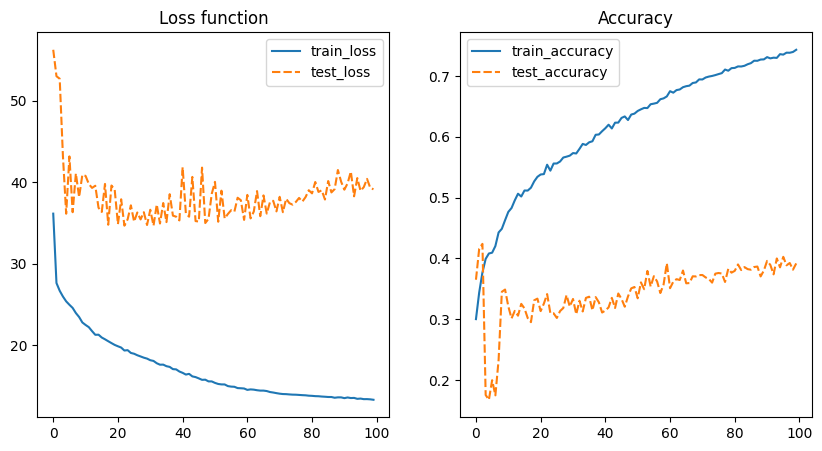

In [148]:
df = pd.DataFrame(data=history)

# Plot the learning curves (the loss function and the accuracy metric)
# which calculated on the training and validation datasets
_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=df[['train_loss', 'test_loss']], ax=axs[0])
sns.lineplot(data=df[['train_accuracy', 'test_accuracy']], ax=axs[1])
axs[0].set_title('Loss function')
axs[1].set_title('Accuracy')
plt.show()

In [161]:
x = encoder_vec.predict(['school'], is_padding=False)
x

[[9]]

In [172]:
X_encoder[20], Y_decoder[20]

([4, 5, 50, 15, 51, 52],
 array([ 8, 55, 56, 57,  3,  0,  0,  0,  0,  0], dtype=int32))

In [173]:
model.predict(np.array([X_encoder[20]]))

[8, 18, 55, 3]

In [163]:
decoder_vec.vocabulary[610]

'мы'

In [141]:
input_phrases[40]

'Tom was visibly disappointed.'